In [8]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import IPython.display
import pickle
import os
from tqdm import tqdm
import collections
import json
import torch
import torch.nn.functional as F
import sys
import numpy as np


sys.path.append('..')
from src.train import Trainer
from src.utils import set_requires_grad
from clsmodel import mnist, stl10, afhq, vafhq

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# load exp config
model_path = '/vol/biomedic2/agk21/PhDLogs/codes/SYB3/LOGS/AFHQ2/models/best.pth'

#data-folder-path
folder_path = '/vol/biomedic2/agk21/PhDLogs/datasets/AFHQ/afhq'

config = json.load(open(os.path.join(os.path.dirname(os.path.dirname(model_path)), 'exp-config.json'), 'r'))

config['classifier'] = vafhq(32, True).cuda(0)
# config['classifier'] = afhq(3, True).cuda(0)

model = Trainer(**config)
model.load_model(model_path)
model.eval()


# model defns
feature_extractor = model.feature_extractor
conti_classifier = model.classifier_baseline
dis_classifier = model.classifier_quantized
decoder = model.dec
codebook_sampler = model.modelclass


# set_requires_grad(classifier, False)
set_requires_grad(feature_extractor, False)
set_requires_grad(conti_classifier, False)
set_requires_grad(dis_classifier, False)
set_requires_grad(decoder, False)
set_requires_grad(codebook_sampler, False)
    

# required config variables 
image_size = model.input_size
latent_dim = model.latent_size
num_classes = model.nclasses

AFHQ weights loaded from  /vol/biomedic2/agk21/PhDLogs/codes/stylEX-extention/Classifier/Logs/AFHQVanilla/best.pth
Building data loader with 16 workers
True
3 2 2 2
FeatureExtractor: Total number of trainable params: 0/28640
ContiClassifier: Total number of trainable params: 0/3075
codebook: Total number of trainable params: 3193609/3193609
DisClassifier: Total number of trainable params: 1539/1539
Decoder: Total number of trainable params: 8247363/8247363
Model loaded from /vol/biomedic2/agk21/PhDLogs/codes/SYB3/LOGS/AFHQ2/models/best.pth, loaded epoch:10 with stats: {'loss': 2.6808996, 'f1': 0.9913333333333333, 'acc': 0.9913333333333333, 'rloss': 0.048181757}


In [10]:
from src.dataset import get

batch_size = 16
train_loader, test_loader = get(batch_size, 
                      data_root = folder_path, 
                      train=True, val=True, 
                      input_size = image_size,
                      num_workers=10)


orig_images = []; orig_labels = []
for (img_batch, label_batch, *context_batch) in tqdm(test_loader):
    img_batch = img_batch.cuda(0)
    label_batch = label_batch.cuda(0)
    orig_images.extend(img_batch)
    orig_labels.extend(label_batch)


labels_ = np.array([lb.cpu().numpy() for lb in orig_labels])
# generate sample dataset
def get_sample_data(N_datapoints = 10): 
    sample_images = []; sample_labels = []
    for ci in range(num_classes):
        idxs = np.where(labels_ == ci)[0]
        randidxs = idxs[np.random.randint(0, len(idxs), N_datapoints//num_classes)]

        for idx in randidxs:
            sample_images.append(orig_images[idx].unsqueeze(0))
            sample_labels.append(orig_labels[idx].unsqueeze(0))

    sample_images = torch.cat(sample_images, dim = 0)
    sample_labels = torch.cat(sample_labels, dim = 0)
    return sample_images, sample_labels

Building data loader with 10 workers


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:04<00:00, 20.58it/s]


1977


915it [02:00,  7.62it/s]


378


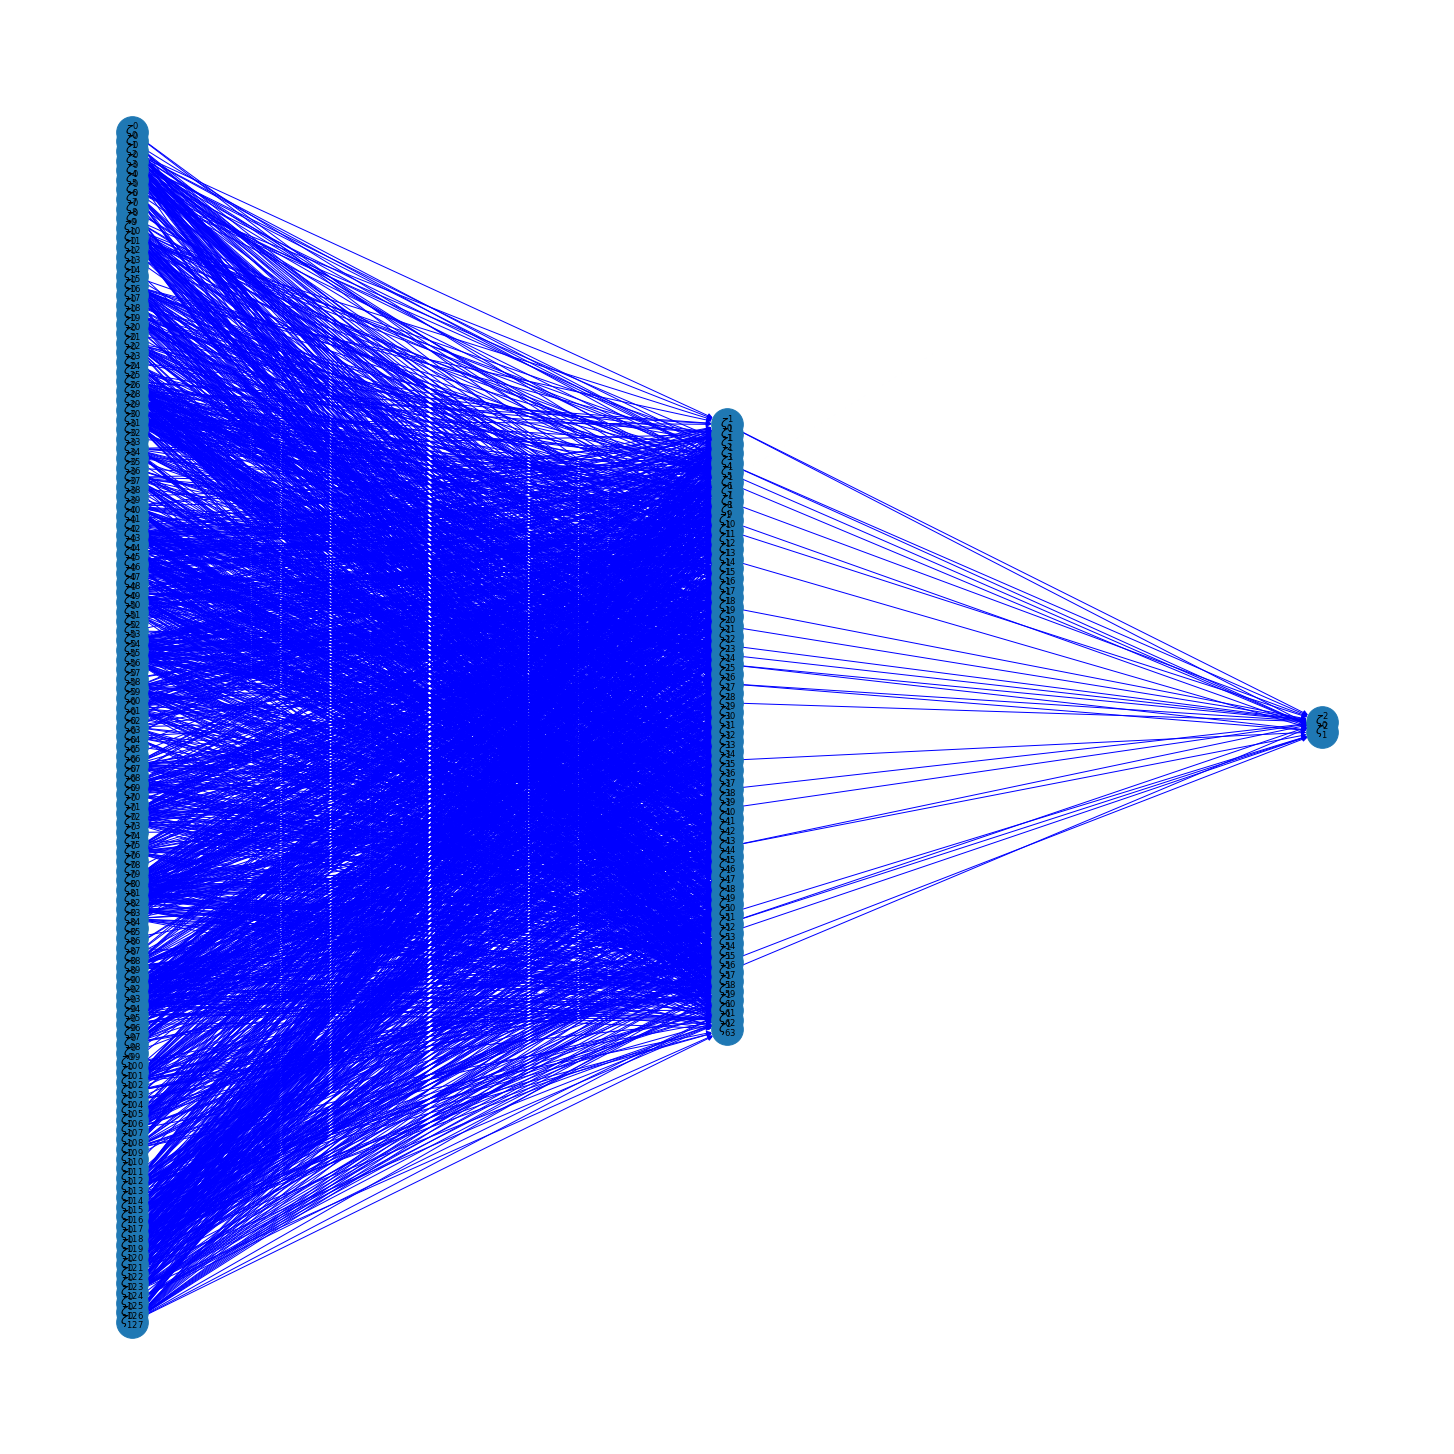

In [11]:
from src.inference import InductiveReasoningDT

inferer = InductiveReasoningDT(get_sample_data(100),
                               ncodebook_features = model.codebook_size,
                               nclasses = num_classes,
                               train_loader = train_loader,
                               feature_extractor = feature_extractor,
                               codebook = codebook_sampler,
                               classifier = dis_classifier,
                               decoder = decoder,
                               class_mapping = {0: 'cat', 1: 'dog', 2:'wild'})

                               

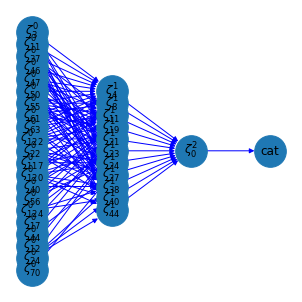

In [39]:
inferer.get_class_tree(0,'./AFHQLOGS/cat')

$\zeta^{2}_{0}$ ['$\\zeta^{1}_{4}$', '$\\zeta^{1}_{8}$', '$\\zeta^{1}_{11}$', '$\\zeta^{1}_{19}$', '$\\zeta^{1}_{21}$', '$\\zeta^{1}_{23}$', '$\\zeta^{1}_{24}$', '$\\zeta^{1}_{27}$', '$\\zeta^{1}_{38}$', '$\\zeta^{1}_{40}$', '$\\zeta^{1}_{44}$'] [21 42]
$\zeta^{2}_{1}$ ['$\\zeta^{1}_{4}$', '$\\zeta^{1}_{6}$', '$\\zeta^{1}_{10}$', '$\\zeta^{1}_{27}$', '$\\zeta^{1}_{35}$', '$\\zeta^{1}_{44}$', '$\\zeta^{1}_{51}$', '$\\zeta^{1}_{53}$', '$\\zeta^{1}_{56}$'] [21 42]
$\zeta^{1}_{21}$ ['$\\zeta^{0}_{3}$', '$\\zeta^{0}_{17}$', '$\\zeta^{0}_{22}$', '$\\zeta^{0}_{40}$', '$\\zeta^{0}_{44}$', '$\\zeta^{0}_{50}$', '$\\zeta^{0}_{55}$', '$\\zeta^{0}_{122}$'] [  0   1   2   3   5   6  12  13  14  17  22  24  35  42  45  48  50  51
  55  56  57  58  61  64  65  66  67  70  71  74  78  83  90 100 104 105
 108 115 117 120 121 122 124]
$\zeta^{2}_{0}$ ['$\\zeta^{1}_{4}$', '$\\zeta^{1}_{8}$', '$\\zeta^{1}_{11}$', '$\\zeta^{1}_{19}$', '$\\zeta^{1}_{21}$', '$\\zeta^{1}_{23}$', '$\\zeta^{1}_{24}$', '$\\zeta^{

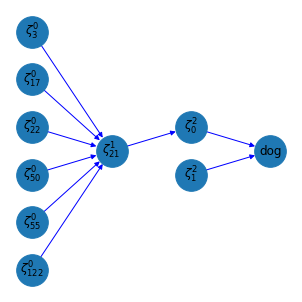

<Figure size 288x288 with 0 Axes>

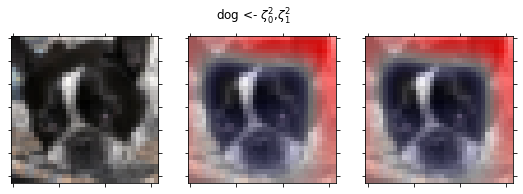

*************** Level-1 heirarchy **************
$\zeta^{2}_{0}$ <- $\zeta^{1}_{21}$


<Figure size 432x288 with 0 Axes>

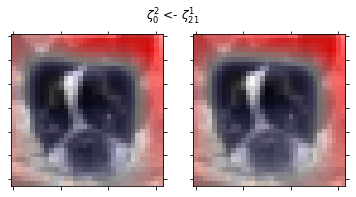

*************** Level-2 heirarchy **************
$\zeta^{1}_{21}$ <- $\zeta^{0}_{3}$,$\zeta^{0}_{17}$,$\zeta^{0}_{22}$,$\zeta^{0}_{50}$,$\zeta^{0}_{55}$,$\zeta^{0}_{122}$


<Figure size 432x288 with 0 Axes>

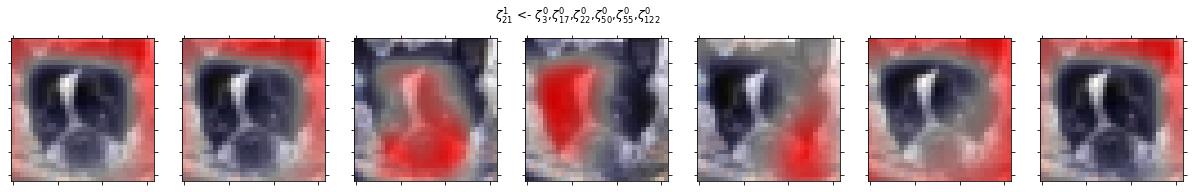

$\zeta^{2}_{0}$ ['$\\zeta^{1}_{4}$', '$\\zeta^{1}_{8}$', '$\\zeta^{1}_{11}$', '$\\zeta^{1}_{19}$', '$\\zeta^{1}_{21}$', '$\\zeta^{1}_{23}$', '$\\zeta^{1}_{24}$', '$\\zeta^{1}_{27}$', '$\\zeta^{1}_{38}$', '$\\zeta^{1}_{40}$', '$\\zeta^{1}_{44}$'] [21 42]
$\zeta^{2}_{1}$ ['$\\zeta^{1}_{4}$', '$\\zeta^{1}_{6}$', '$\\zeta^{1}_{10}$', '$\\zeta^{1}_{27}$', '$\\zeta^{1}_{35}$', '$\\zeta^{1}_{44}$', '$\\zeta^{1}_{51}$', '$\\zeta^{1}_{53}$', '$\\zeta^{1}_{56}$'] [21 42]
$\zeta^{1}_{21}$ ['$\\zeta^{0}_{3}$', '$\\zeta^{0}_{17}$', '$\\zeta^{0}_{22}$', '$\\zeta^{0}_{40}$', '$\\zeta^{0}_{44}$', '$\\zeta^{0}_{50}$', '$\\zeta^{0}_{55}$', '$\\zeta^{0}_{122}$'] [  3   6  13  14  22  24  37  40  43  46  47  50  52  53  55  58  61  63
  64  70  86 100 101 104 105 115 117 122]
$\zeta^{2}_{0}$ ['$\\zeta^{1}_{4}$', '$\\zeta^{1}_{8}$', '$\\zeta^{1}_{11}$', '$\\zeta^{1}_{19}$', '$\\zeta^{1}_{21}$', '$\\zeta^{1}_{23}$', '$\\zeta^{1}_{24}$', '$\\zeta^{1}_{27}$', '$\\zeta^{1}_{38}$', '$\\zeta^{1}_{40}$', '$\\zeta

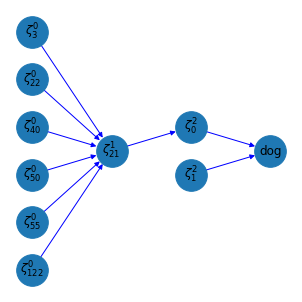

<Figure size 288x288 with 0 Axes>

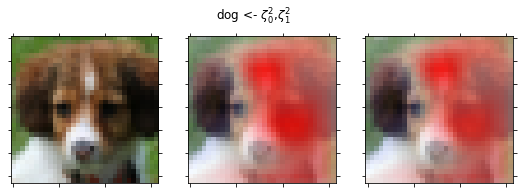

*************** Level-1 heirarchy **************
$\zeta^{2}_{0}$ <- $\zeta^{1}_{21}$


<Figure size 432x288 with 0 Axes>

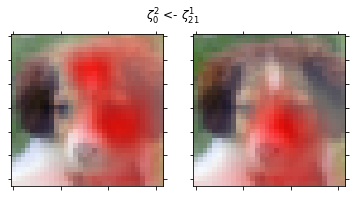

*************** Level-2 heirarchy **************
$\zeta^{1}_{21}$ <- $\zeta^{0}_{3}$,$\zeta^{0}_{22}$,$\zeta^{0}_{40}$,$\zeta^{0}_{50}$,$\zeta^{0}_{55}$,$\zeta^{0}_{122}$


<Figure size 432x288 with 0 Axes>

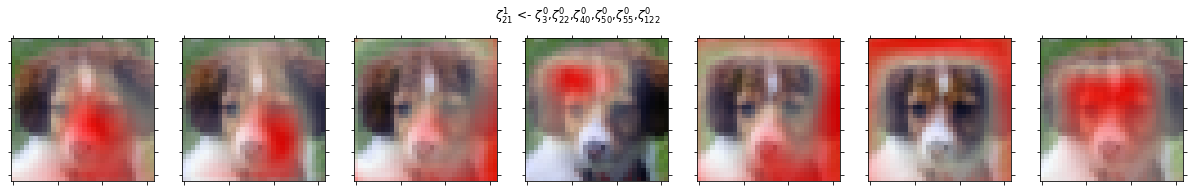

$\zeta^{2}_{0}$ ['$\\zeta^{1}_{4}$', '$\\zeta^{1}_{8}$', '$\\zeta^{1}_{11}$', '$\\zeta^{1}_{19}$', '$\\zeta^{1}_{21}$', '$\\zeta^{1}_{23}$', '$\\zeta^{1}_{24}$', '$\\zeta^{1}_{27}$', '$\\zeta^{1}_{38}$', '$\\zeta^{1}_{40}$', '$\\zeta^{1}_{44}$'] [21 42 61]
$\zeta^{2}_{1}$ ['$\\zeta^{1}_{4}$', '$\\zeta^{1}_{6}$', '$\\zeta^{1}_{10}$', '$\\zeta^{1}_{27}$', '$\\zeta^{1}_{35}$', '$\\zeta^{1}_{44}$', '$\\zeta^{1}_{51}$', '$\\zeta^{1}_{53}$', '$\\zeta^{1}_{56}$'] [21 42 61]
$\zeta^{1}_{21}$ ['$\\zeta^{0}_{3}$', '$\\zeta^{0}_{17}$', '$\\zeta^{0}_{22}$', '$\\zeta^{0}_{40}$', '$\\zeta^{0}_{44}$', '$\\zeta^{0}_{50}$', '$\\zeta^{0}_{55}$', '$\\zeta^{0}_{122}$'] [  3   4   6  11  12  13  15  16  17  21  22  24  27  31  37  38  43  44
  46  50  51  52  55  56  57  58  60  61  64  67  70  87  90  95  97 100
 104 105 113 115 116 117 121 122 125]
$\zeta^{2}_{0}$ ['$\\zeta^{1}_{4}$', '$\\zeta^{1}_{8}$', '$\\zeta^{1}_{11}$', '$\\zeta^{1}_{19}$', '$\\zeta^{1}_{21}$', '$\\zeta^{1}_{23}$', '$\\zeta^{1}_{24}

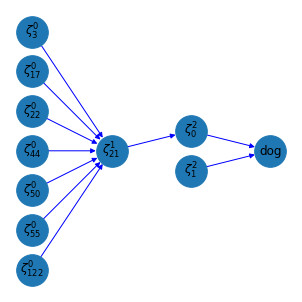

<Figure size 288x288 with 0 Axes>

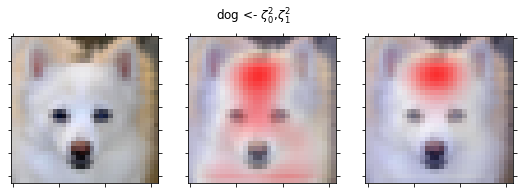

*************** Level-1 heirarchy **************
$\zeta^{2}_{0}$ <- $\zeta^{1}_{21}$


<Figure size 432x288 with 0 Axes>

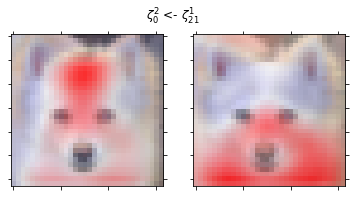

*************** Level-2 heirarchy **************
$\zeta^{1}_{21}$ <- $\zeta^{0}_{3}$,$\zeta^{0}_{17}$,$\zeta^{0}_{22}$,$\zeta^{0}_{44}$,$\zeta^{0}_{50}$,$\zeta^{0}_{55}$,$\zeta^{0}_{122}$


<Figure size 432x288 with 0 Axes>

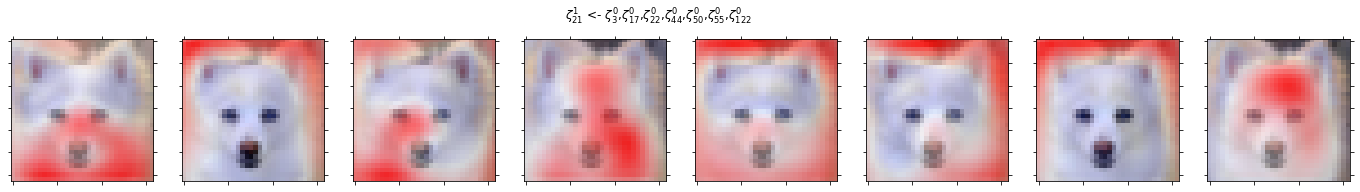

$\zeta^{2}_{0}$ ['$\\zeta^{1}_{4}$', '$\\zeta^{1}_{8}$', '$\\zeta^{1}_{11}$', '$\\zeta^{1}_{19}$', '$\\zeta^{1}_{21}$', '$\\zeta^{1}_{23}$', '$\\zeta^{1}_{24}$', '$\\zeta^{1}_{27}$', '$\\zeta^{1}_{38}$', '$\\zeta^{1}_{40}$', '$\\zeta^{1}_{44}$'] [21 42]
$\zeta^{2}_{1}$ ['$\\zeta^{1}_{4}$', '$\\zeta^{1}_{6}$', '$\\zeta^{1}_{10}$', '$\\zeta^{1}_{27}$', '$\\zeta^{1}_{35}$', '$\\zeta^{1}_{44}$', '$\\zeta^{1}_{51}$', '$\\zeta^{1}_{53}$', '$\\zeta^{1}_{56}$'] [21 42]
$\zeta^{1}_{21}$ ['$\\zeta^{0}_{3}$', '$\\zeta^{0}_{17}$', '$\\zeta^{0}_{22}$', '$\\zeta^{0}_{40}$', '$\\zeta^{0}_{44}$', '$\\zeta^{0}_{50}$', '$\\zeta^{0}_{55}$', '$\\zeta^{0}_{122}$'] [  2   3   5  13  14  17  22  24  28  37  40  46  47  48  50  58  61  63
  64  70  74  86 100 104 105 115 117 122 124]
$\zeta^{2}_{0}$ ['$\\zeta^{1}_{4}$', '$\\zeta^{1}_{8}$', '$\\zeta^{1}_{11}$', '$\\zeta^{1}_{19}$', '$\\zeta^{1}_{21}$', '$\\zeta^{1}_{23}$', '$\\zeta^{1}_{24}$', '$\\zeta^{1}_{27}$', '$\\zeta^{1}_{38}$', '$\\zeta^{1}_{40}$', '$\\

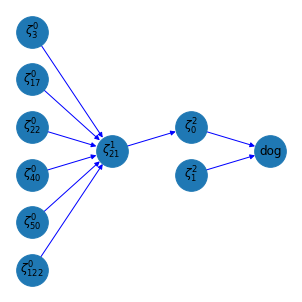

<Figure size 288x288 with 0 Axes>

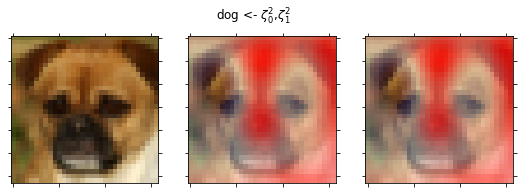

*************** Level-1 heirarchy **************
$\zeta^{2}_{0}$ <- $\zeta^{1}_{21}$


<Figure size 432x288 with 0 Axes>

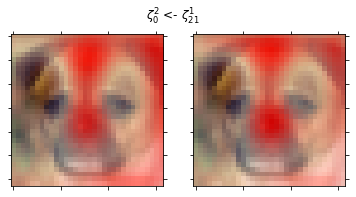

*************** Level-2 heirarchy **************
$\zeta^{1}_{21}$ <- $\zeta^{0}_{3}$,$\zeta^{0}_{17}$,$\zeta^{0}_{22}$,$\zeta^{0}_{40}$,$\zeta^{0}_{50}$,$\zeta^{0}_{122}$


<Figure size 432x288 with 0 Axes>

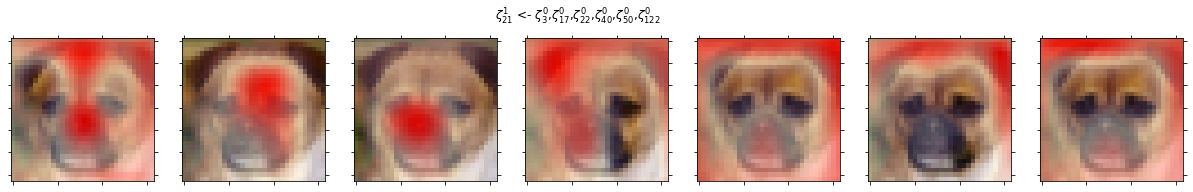

$\zeta^{2}_{0}$ ['$\\zeta^{1}_{4}$', '$\\zeta^{1}_{8}$', '$\\zeta^{1}_{11}$', '$\\zeta^{1}_{19}$', '$\\zeta^{1}_{21}$', '$\\zeta^{1}_{23}$', '$\\zeta^{1}_{24}$', '$\\zeta^{1}_{27}$', '$\\zeta^{1}_{38}$', '$\\zeta^{1}_{40}$', '$\\zeta^{1}_{44}$'] [21 42]
$\zeta^{2}_{1}$ ['$\\zeta^{1}_{4}$', '$\\zeta^{1}_{6}$', '$\\zeta^{1}_{10}$', '$\\zeta^{1}_{27}$', '$\\zeta^{1}_{35}$', '$\\zeta^{1}_{44}$', '$\\zeta^{1}_{51}$', '$\\zeta^{1}_{53}$', '$\\zeta^{1}_{56}$'] [21 42]
$\zeta^{1}_{21}$ ['$\\zeta^{0}_{3}$', '$\\zeta^{0}_{17}$', '$\\zeta^{0}_{22}$', '$\\zeta^{0}_{40}$', '$\\zeta^{0}_{44}$', '$\\zeta^{0}_{50}$', '$\\zeta^{0}_{55}$', '$\\zeta^{0}_{122}$'] [  2   3   5   6  13  14  22  28  35  37  40  46  48  50  52  58  61  63
  64  70  71  86 100 105 108 115 117]
$\zeta^{2}_{0}$ ['$\\zeta^{1}_{4}$', '$\\zeta^{1}_{8}$', '$\\zeta^{1}_{11}$', '$\\zeta^{1}_{19}$', '$\\zeta^{1}_{21}$', '$\\zeta^{1}_{23}$', '$\\zeta^{1}_{24}$', '$\\zeta^{1}_{27}$', '$\\zeta^{1}_{38}$', '$\\zeta^{1}_{40}$', '$\\zeta^{1}

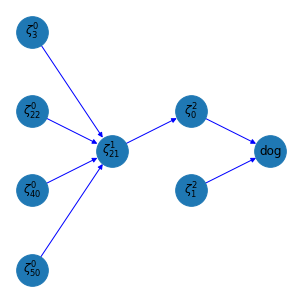

<Figure size 288x288 with 0 Axes>

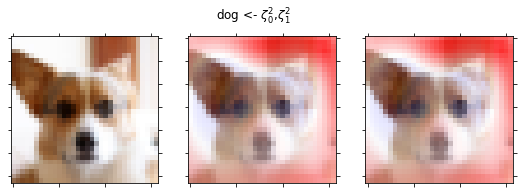

*************** Level-1 heirarchy **************
$\zeta^{2}_{0}$ <- $\zeta^{1}_{21}$


<Figure size 432x288 with 0 Axes>

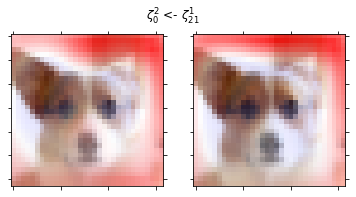

*************** Level-2 heirarchy **************
$\zeta^{1}_{21}$ <- $\zeta^{0}_{3}$,$\zeta^{0}_{22}$,$\zeta^{0}_{40}$,$\zeta^{0}_{50}$


<Figure size 432x288 with 0 Axes>

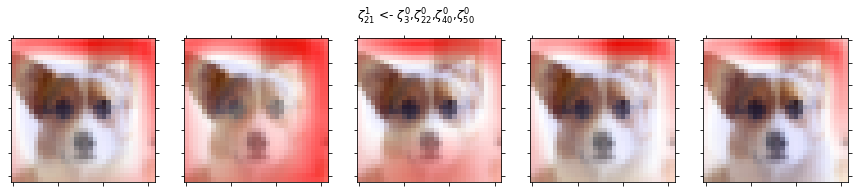

$\zeta^{2}_{0}$ ['$\\zeta^{1}_{4}$', '$\\zeta^{1}_{8}$', '$\\zeta^{1}_{11}$', '$\\zeta^{1}_{19}$', '$\\zeta^{1}_{21}$', '$\\zeta^{1}_{23}$', '$\\zeta^{1}_{24}$', '$\\zeta^{1}_{27}$', '$\\zeta^{1}_{38}$', '$\\zeta^{1}_{40}$', '$\\zeta^{1}_{44}$'] [21 42]
$\zeta^{2}_{1}$ ['$\\zeta^{1}_{4}$', '$\\zeta^{1}_{6}$', '$\\zeta^{1}_{10}$', '$\\zeta^{1}_{27}$', '$\\zeta^{1}_{35}$', '$\\zeta^{1}_{44}$', '$\\zeta^{1}_{51}$', '$\\zeta^{1}_{53}$', '$\\zeta^{1}_{56}$'] [21 42]
$\zeta^{1}_{21}$ ['$\\zeta^{0}_{3}$', '$\\zeta^{0}_{17}$', '$\\zeta^{0}_{22}$', '$\\zeta^{0}_{40}$', '$\\zeta^{0}_{44}$', '$\\zeta^{0}_{50}$', '$\\zeta^{0}_{55}$', '$\\zeta^{0}_{122}$'] [  5  13  14  22  28  37  40  46  50  52  58  63  64  71  86 100 115 117]
$\zeta^{2}_{0}$ ['$\\zeta^{1}_{4}$', '$\\zeta^{1}_{8}$', '$\\zeta^{1}_{11}$', '$\\zeta^{1}_{19}$', '$\\zeta^{1}_{21}$', '$\\zeta^{1}_{23}$', '$\\zeta^{1}_{24}$', '$\\zeta^{1}_{27}$', '$\\zeta^{1}_{38}$', '$\\zeta^{1}_{40}$', '$\\zeta^{1}_{44}$'] [21 42]
$\zeta^{2}_{1}$ ['$\

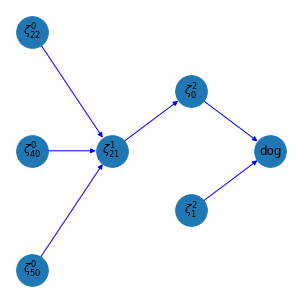

<Figure size 288x288 with 0 Axes>

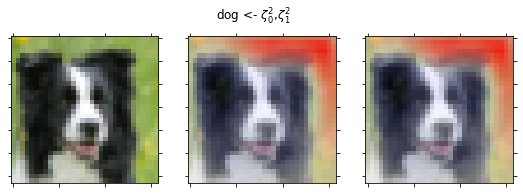

*************** Level-1 heirarchy **************
$\zeta^{2}_{0}$ <- $\zeta^{1}_{21}$


<Figure size 432x288 with 0 Axes>

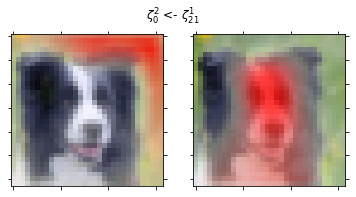

*************** Level-2 heirarchy **************
$\zeta^{1}_{21}$ <- $\zeta^{0}_{22}$,$\zeta^{0}_{40}$,$\zeta^{0}_{50}$


<Figure size 432x288 with 0 Axes>

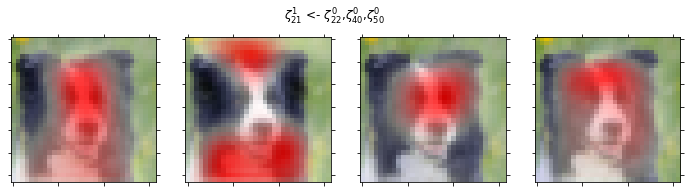

$\zeta^{2}_{0}$ ['$\\zeta^{1}_{4}$', '$\\zeta^{1}_{8}$', '$\\zeta^{1}_{11}$', '$\\zeta^{1}_{19}$', '$\\zeta^{1}_{21}$', '$\\zeta^{1}_{23}$', '$\\zeta^{1}_{24}$', '$\\zeta^{1}_{27}$', '$\\zeta^{1}_{38}$', '$\\zeta^{1}_{40}$', '$\\zeta^{1}_{44}$'] [21 42]
$\zeta^{2}_{1}$ ['$\\zeta^{1}_{4}$', '$\\zeta^{1}_{6}$', '$\\zeta^{1}_{10}$', '$\\zeta^{1}_{27}$', '$\\zeta^{1}_{35}$', '$\\zeta^{1}_{44}$', '$\\zeta^{1}_{51}$', '$\\zeta^{1}_{53}$', '$\\zeta^{1}_{56}$'] [21 42]
$\zeta^{1}_{21}$ ['$\\zeta^{0}_{3}$', '$\\zeta^{0}_{17}$', '$\\zeta^{0}_{22}$', '$\\zeta^{0}_{40}$', '$\\zeta^{0}_{44}$', '$\\zeta^{0}_{50}$', '$\\zeta^{0}_{55}$', '$\\zeta^{0}_{122}$'] [  2   5  12  13  14  17  22  28  35  37  40  44  46  47  50  57  58  61
  63  64  70  71  86 101 105 115 117 120]
$\zeta^{2}_{0}$ ['$\\zeta^{1}_{4}$', '$\\zeta^{1}_{8}$', '$\\zeta^{1}_{11}$', '$\\zeta^{1}_{19}$', '$\\zeta^{1}_{21}$', '$\\zeta^{1}_{23}$', '$\\zeta^{1}_{24}$', '$\\zeta^{1}_{27}$', '$\\zeta^{1}_{38}$', '$\\zeta^{1}_{40}$', '$\\zeta

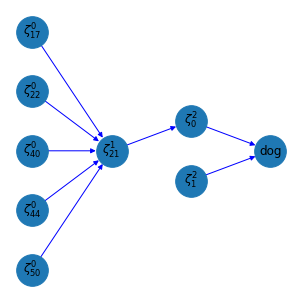

<Figure size 288x288 with 0 Axes>

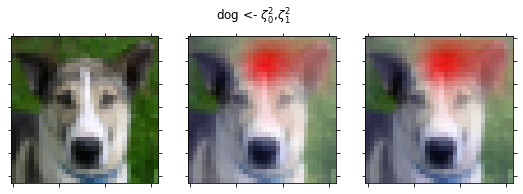

*************** Level-1 heirarchy **************
$\zeta^{2}_{0}$ <- $\zeta^{1}_{21}$


<Figure size 432x288 with 0 Axes>

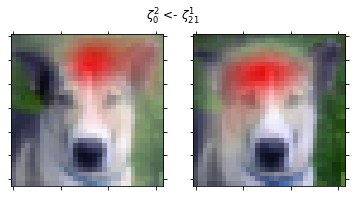

*************** Level-2 heirarchy **************
$\zeta^{1}_{21}$ <- $\zeta^{0}_{17}$,$\zeta^{0}_{22}$,$\zeta^{0}_{40}$,$\zeta^{0}_{44}$,$\zeta^{0}_{50}$


<Figure size 432x288 with 0 Axes>

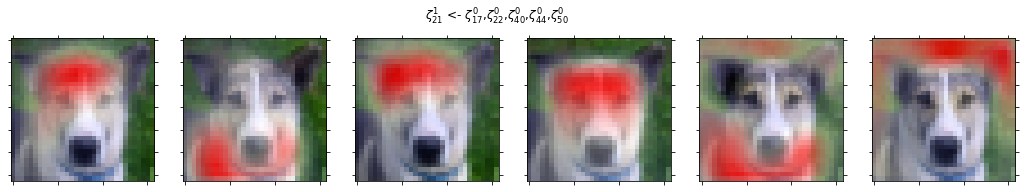

$\zeta^{2}_{0}$ ['$\\zeta^{1}_{4}$', '$\\zeta^{1}_{8}$', '$\\zeta^{1}_{11}$', '$\\zeta^{1}_{19}$', '$\\zeta^{1}_{21}$', '$\\zeta^{1}_{23}$', '$\\zeta^{1}_{24}$', '$\\zeta^{1}_{27}$', '$\\zeta^{1}_{38}$', '$\\zeta^{1}_{40}$', '$\\zeta^{1}_{44}$'] [21 42]
$\zeta^{2}_{1}$ ['$\\zeta^{1}_{4}$', '$\\zeta^{1}_{6}$', '$\\zeta^{1}_{10}$', '$\\zeta^{1}_{27}$', '$\\zeta^{1}_{35}$', '$\\zeta^{1}_{44}$', '$\\zeta^{1}_{51}$', '$\\zeta^{1}_{53}$', '$\\zeta^{1}_{56}$'] [21 42]
$\zeta^{1}_{21}$ ['$\\zeta^{0}_{3}$', '$\\zeta^{0}_{17}$', '$\\zeta^{0}_{22}$', '$\\zeta^{0}_{40}$', '$\\zeta^{0}_{44}$', '$\\zeta^{0}_{50}$', '$\\zeta^{0}_{55}$', '$\\zeta^{0}_{122}$'] [  3   5  12  13  14  22  37  40  44  46  47  50  52  53  55  57  58  63
  64  70  71  86 100 105 117 120]
$\zeta^{2}_{0}$ ['$\\zeta^{1}_{4}$', '$\\zeta^{1}_{8}$', '$\\zeta^{1}_{11}$', '$\\zeta^{1}_{19}$', '$\\zeta^{1}_{21}$', '$\\zeta^{1}_{23}$', '$\\zeta^{1}_{24}$', '$\\zeta^{1}_{27}$', '$\\zeta^{1}_{38}$', '$\\zeta^{1}_{40}$', '$\\zeta^{1}_{44

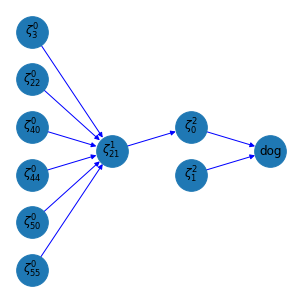

<Figure size 288x288 with 0 Axes>

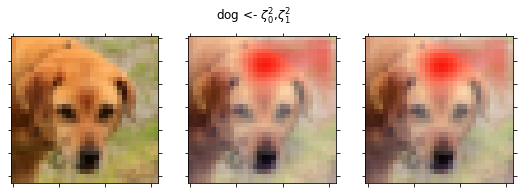

*************** Level-1 heirarchy **************
$\zeta^{2}_{0}$ <- $\zeta^{1}_{21}$


<Figure size 432x288 with 0 Axes>

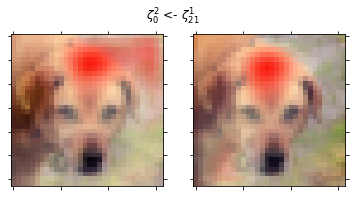

*************** Level-2 heirarchy **************
$\zeta^{1}_{21}$ <- $\zeta^{0}_{3}$,$\zeta^{0}_{22}$,$\zeta^{0}_{40}$,$\zeta^{0}_{44}$,$\zeta^{0}_{50}$,$\zeta^{0}_{55}$


<Figure size 432x288 with 0 Axes>

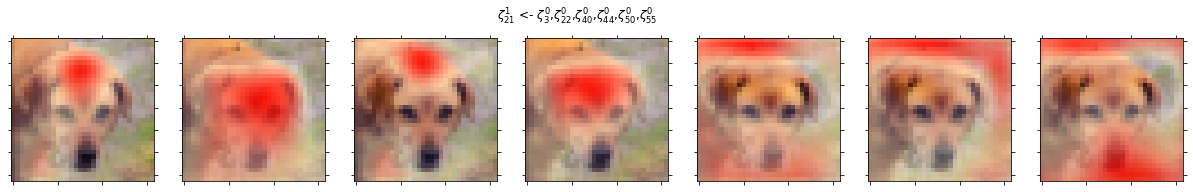

$\zeta^{2}_{0}$ ['$\\zeta^{1}_{4}$', '$\\zeta^{1}_{8}$', '$\\zeta^{1}_{11}$', '$\\zeta^{1}_{19}$', '$\\zeta^{1}_{21}$', '$\\zeta^{1}_{23}$', '$\\zeta^{1}_{24}$', '$\\zeta^{1}_{27}$', '$\\zeta^{1}_{38}$', '$\\zeta^{1}_{40}$', '$\\zeta^{1}_{44}$'] [ 0 14 15 16 17 21 25 26 31 34 36 42 43 45 52 55 59 61]
$\zeta^{2}_{1}$ ['$\\zeta^{1}_{4}$', '$\\zeta^{1}_{6}$', '$\\zeta^{1}_{10}$', '$\\zeta^{1}_{27}$', '$\\zeta^{1}_{35}$', '$\\zeta^{1}_{44}$', '$\\zeta^{1}_{51}$', '$\\zeta^{1}_{53}$', '$\\zeta^{1}_{56}$'] [ 0 14 15 16 17 21 25 26 31 34 36 42 43 45 52 55 59 61]
$\zeta^{1}_{21}$ ['$\\zeta^{0}_{3}$', '$\\zeta^{0}_{17}$', '$\\zeta^{0}_{22}$', '$\\zeta^{0}_{40}$', '$\\zeta^{0}_{44}$', '$\\zeta^{0}_{50}$', '$\\zeta^{0}_{55}$', '$\\zeta^{0}_{122}$'] [  0   1   3   4   8  13  14  15  16  19  20  21  23  24  28  29  30  31
  32  34  35  36  39  40  41  42  43  45  48  54  55  56  58  59  60  64
  65  70  71  72  74  75  76  78  83  86  90  93  94  96  97  99 100 102
 103 104 106 107 108 111 112 113 

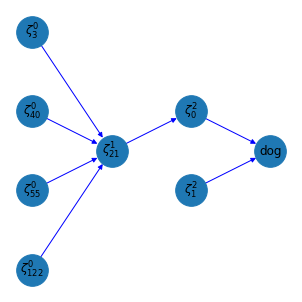

<Figure size 288x288 with 0 Axes>

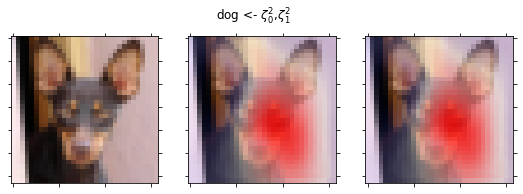

*************** Level-1 heirarchy **************
$\zeta^{2}_{0}$ <- $\zeta^{1}_{21}$


<Figure size 432x288 with 0 Axes>

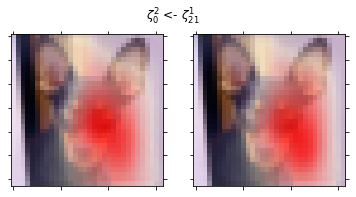

*************** Level-2 heirarchy **************
$\zeta^{1}_{21}$ <- $\zeta^{0}_{3}$,$\zeta^{0}_{40}$,$\zeta^{0}_{55}$,$\zeta^{0}_{122}$


<Figure size 432x288 with 0 Axes>

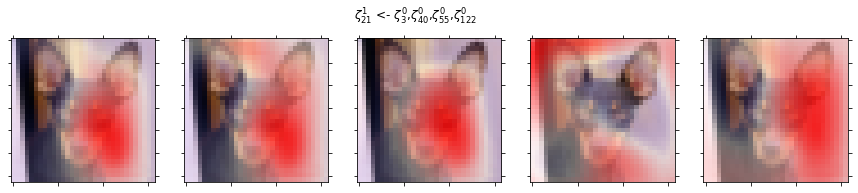

$\zeta^{2}_{0}$ ['$\\zeta^{1}_{4}$', '$\\zeta^{1}_{8}$', '$\\zeta^{1}_{11}$', '$\\zeta^{1}_{19}$', '$\\zeta^{1}_{21}$', '$\\zeta^{1}_{23}$', '$\\zeta^{1}_{24}$', '$\\zeta^{1}_{27}$', '$\\zeta^{1}_{38}$', '$\\zeta^{1}_{40}$', '$\\zeta^{1}_{44}$'] [21 42]
$\zeta^{2}_{1}$ ['$\\zeta^{1}_{4}$', '$\\zeta^{1}_{6}$', '$\\zeta^{1}_{10}$', '$\\zeta^{1}_{27}$', '$\\zeta^{1}_{35}$', '$\\zeta^{1}_{44}$', '$\\zeta^{1}_{51}$', '$\\zeta^{1}_{53}$', '$\\zeta^{1}_{56}$'] [21 42]
$\zeta^{1}_{21}$ ['$\\zeta^{0}_{3}$', '$\\zeta^{0}_{17}$', '$\\zeta^{0}_{22}$', '$\\zeta^{0}_{40}$', '$\\zeta^{0}_{44}$', '$\\zeta^{0}_{50}$', '$\\zeta^{0}_{55}$', '$\\zeta^{0}_{122}$'] [  0   1   3   5   6  11  12  13  14  15  17  19  22  24  27  28  30  31
  37  38  40  43  46  47  48  50  52  53  55  56  58  61  63  64  67  70
  71  74  86  93  95  97 100 101 103 104 105 108 110 115 117 120 121 124
 125]
$\zeta^{2}_{0}$ ['$\\zeta^{1}_{4}$', '$\\zeta^{1}_{8}$', '$\\zeta^{1}_{11}$', '$\\zeta^{1}_{19}$', '$\\zeta^{1}_{21}$', '$\

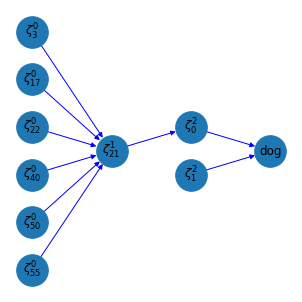

<Figure size 288x288 with 0 Axes>

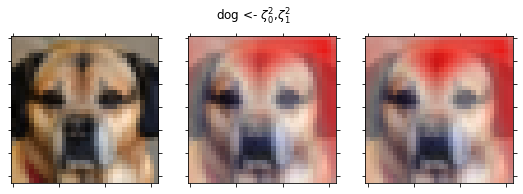

*************** Level-1 heirarchy **************
$\zeta^{2}_{0}$ <- $\zeta^{1}_{21}$


<Figure size 432x288 with 0 Axes>

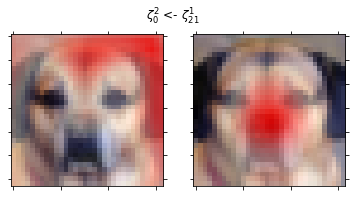

*************** Level-2 heirarchy **************
$\zeta^{1}_{21}$ <- $\zeta^{0}_{3}$,$\zeta^{0}_{17}$,$\zeta^{0}_{22}$,$\zeta^{0}_{40}$,$\zeta^{0}_{50}$,$\zeta^{0}_{55}$


<Figure size 432x288 with 0 Axes>

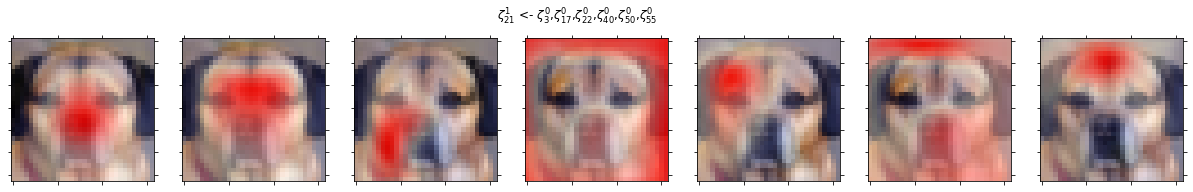

In [47]:
class_idx = 1
    
for i in range(10):
    x,y = get_sample_data(num_classes)
    x = x[class_idx].unsqueeze(0)

    inferer.get_local_tree(class_idx, x, f'./AFHQLOGS/dog/img{i}')
    inferer.query(class_idx, visual = x, local=True, overlay=True, save_path=f'./AFHQLOGS/dog/img{i}')